# Introduction

Let's help Santa optimize his route and figure out the best way to travel the world! 

We'll be using data from simplemaps World Cities Database.

### Notebook setup
We will install libraries and then import them after.

In [1]:
# install libraries
!pip install geopandas
!pip install networkx
!pip install pulp

     |████████████████████████████████| 1.0 MB 11.2 MB/s            
     |████████████████████████████████| 1.2 MB 30.5 MB/s            
     |████████████████████████████████| 7.7 MB 39.6 MB/s            
     |████████████████████████████████| 19.3 MB 12.9 MB/s            
     |████████████████████████████████| 14.2 MB 8.4 MB/s            


In [2]:
# import libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import time
import math
import numpy as np

from tqdm import tqdm
from pulp import *
from shapely.geometry import LineString

### Read the data

In [3]:
# read the xlsx online
df = pd.read_excel("https://bit.ly/worldcitiesuplevel")
df

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Delhi,Delhi,28.6600,77.2300,India,IN,IND,Delhi,admin,29617000.0,1356872604
3,Mumbai,Mumbai,18.9667,72.8333,India,IN,IND,Mahārāshtra,admin,23355000.0,1356226629
4,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140
...,...,...,...,...,...,...,...,...,...,...,...
40996,Tukchi,Tukchi,57.3670,139.5000,Russia,RU,RUS,Khabarovskiy Kray,NaN,10.0,1643472801
40997,Numto,Numto,63.6667,71.3333,Russia,RU,RUS,Khanty-Mansiyskiy Avtonomnyy Okrug-Yugra,NaN,10.0,1643985006
40998,Nord,Nord,81.7166,-17.8000,Greenland,GL,GRL,Sermersooq,NaN,10.0,1304217709
40999,Timmiarmiut,Timmiarmiut,62.5333,-42.2167,Greenland,GL,GRL,Kujalleq,NaN,10.0,1304206491


In [4]:
# sample the rows of data to see what's up
df.sample(20)

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
24950,Kasumkent,Kasumkent,41.6667,48.1333,Russia,RU,RUS,Dagestan,NaN,13232.0,1643247115
1959,Binxian,Binxian,35.0364,108.0764,China,CN,CHN,Shaanxi,NaN,323256.0,1156167534
29384,Axixá do Tocantins,Axixa do Tocantins,-5.6169,-47.7689,Brazil,BR,BRA,Tocantins,NaN,9787.0,1076964042
16092,Emmen,Emmen,47.0772,8.3000,Switzerland,CH,CHE,Luzern,NaN,29292.0,1756487266
38602,Romelândia,Romelandia,-26.6758,-53.3139,Brazil,BR,BRA,Santa Catarina,NaN,5551.0,1076132264
26800,Varzaneh,Varzaneh,32.4194,52.6481,Iran,IR,IRN,Eşfahān,NaN,11506.0,1364732883
20249,Ariccia,Ariccia,41.7167,12.6667,Italy,IT,ITA,Lazio,NaN,18851.0,1380585218
9473,Beltinci,Beltinci,46.6053,16.2406,Slovenia,SI,SVN,Beltinci,admin,2430.0,1705238814
20633,Valenza,Valenza,45.0140,8.6458,Italy,IT,ITA,Piedmont,NaN,18804.0,1380755074
3171,Mülheim,Mulheim,51.4275,6.8825,Germany,DE,DEU,North Rhine-Westphalia,minor,170880.0,1276676856


# Quick EDA
40k cities? That's just too many (for this code-along, at least). Let's explore the dataset and see if we can trim to to a few major rows.

### Get a unique count of countries in dataset
Let's see how many countries there are here. Officially, we have 195 countries.

In [5]:
# get nunique of country
df['country'].nunique()

237

Reason for the difference: https://www.worldometers.info/world-population/population-by-country/

### Plot a barplot of capital vs population

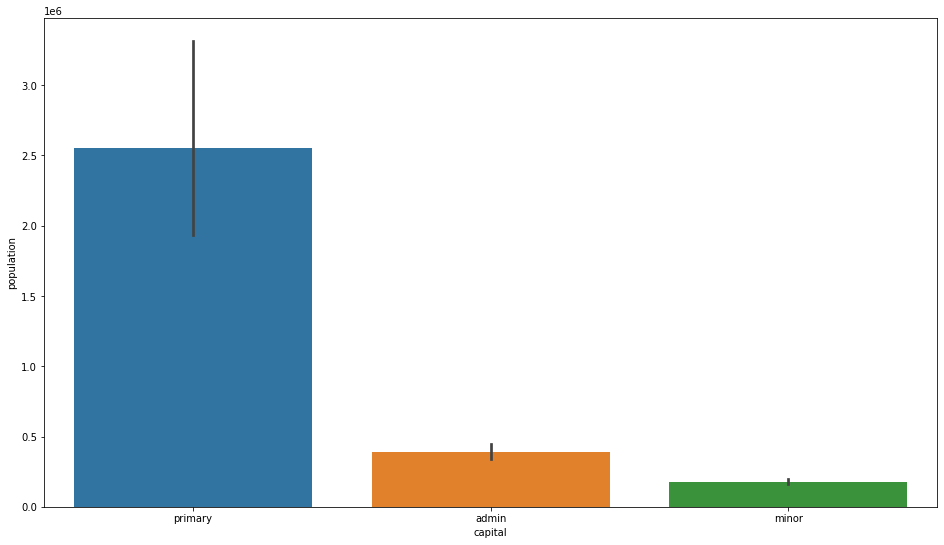

In [6]:
# plot barplot
plt.figure(figsize = (16,9))
sns.barplot(data = df, x = 'capital', y = 'population')

# Data preparation
Now that we've kind of figured out what to filter - let's do that.

### Filter the DataFrame
Let's filter it such that we only have "primary" in the capital column.

In [7]:
# filter the df
primary = df[df['capital'] == 'primary'].dropna(subset = ['population'])
primary

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
4,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140
7,Seoul,Seoul,37.5600,126.9900,"Korea, South",KR,KOR,Seoul,primary,21794000.0,1410836482
8,Mexico City,Mexico City,19.4333,-99.1333,Mexico,MX,MEX,Ciudad de México,primary,20996000.0,1484247881
...,...,...,...,...,...,...,...,...,...,...,...
854,Stanley,Stanley,-51.7000,-57.8500,Falkland Islands (Islas Malvinas),FK,FLK,NaN,primary,2213.0,1238780509
855,Vatican City,Vatican City,41.9000,12.4478,Vatican City,VA,VAT,NaN,primary,825.0,1336000000
856,Alofi,Alofi,-19.0560,-169.9210,Niue,NU,NIU,NaN,primary,1611.0,1570882835
857,Hagåtña,Hagta,13.4745,144.7504,Guam,GU,GUM,NaN,primary,1051.0,1316937540


In [8]:
# sort the primary
primary = primary.sort_values('population', ascending = False)
primary

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
4,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140
7,Seoul,Seoul,37.5600,126.9900,"Korea, South",KR,KOR,Seoul,primary,21794000.0,1410836482
8,Mexico City,Mexico City,19.4333,-99.1333,Mexico,MX,MEX,Ciudad de México,primary,20996000.0,1484247881
...,...,...,...,...,...,...,...,...,...,...,...
854,Stanley,Stanley,-51.7000,-57.8500,Falkland Islands (Islas Malvinas),FK,FLK,NaN,primary,2213.0,1238780509
856,Alofi,Alofi,-19.0560,-169.9210,Niue,NU,NIU,NaN,primary,1611.0,1570882835
857,Hagåtña,Hagta,13.4745,144.7504,Guam,GU,GUM,NaN,primary,1051.0,1316937540
855,Vatican City,Vatican City,41.9000,12.4478,Vatican City,VA,VAT,NaN,primary,825.0,1336000000


In [9]:
# let's check Singapore
primary[primary['city'] == 'Singapore']

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
109,Singapore,Singapore,1.3,103.8,Singapore,SG,SGP,Central Singapore,primary,5745000.0,1702341327


In [10]:
primary.dtypes

city           object
city_ascii     object
lat           float64
lng           float64
country        object
iso2           object
iso3           object
admin_name     object
capital        object
population    float64
id              int64
dtype: object

### Add Santa Claus Village into the GeoDataFrame

In [11]:
# add additional coordinates
north_pole = {"city": "North Pole",
              "city_ascii": None,
              "lat": 66.50,
              "lng": 27.72,
              "country": "Finland",
              "iso2": None,
              "iso3": None,
              "admin_name": None,
              "capital": "primary",
              "population": 100,
              "id": 1}

primary = primary.append(north_pole, ignore_index = True)
primary

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077
2,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140
3,Seoul,Seoul,37.5600,126.9900,"Korea, South",KR,KOR,Seoul,primary,21794000.0,1410836482
4,Mexico City,Mexico City,19.4333,-99.1333,Mexico,MX,MEX,Ciudad de México,primary,20996000.0,1484247881
...,...,...,...,...,...,...,...,...,...,...,...
224,Alofi,Alofi,-19.0560,-169.9210,Niue,NU,NIU,NaN,primary,1611.0,1570882835
225,Hagåtña,Hagta,13.4745,144.7504,Guam,GU,GUM,NaN,primary,1051.0,1316937540
226,Vatican City,Vatican City,41.9000,12.4478,Vatican City,VA,VAT,NaN,primary,825.0,1336000000
227,Jamestown,Jamestown,-15.9251,-5.7179,"Saint Helena, Ascension, And Tristan Da Cunha",SH,SHN,Saint Helena,primary,714.0,1654761576


### Turn pandas DataFrame into geopandas GeoDataFrame
We'll need to plot our coordinates eventually, so let's turn the DataFrame into a GeoDataFrame.

In [12]:
# get the GeoDataFrame of the primary cities
primary_geo = gpd.GeoDataFrame(primary, geometry = gpd.points_from_xy(primary['lng'], primary['lat']), crs = 4326)
primary_geo

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id,geometry
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37977000.0,1392685764,POINT (139.69220 35.68970)
1,Jakarta,Jakarta,-6.2146,106.8451,Indonesia,ID,IDN,Jakarta,primary,34540000.0,1360771077,POINT (106.84510 -6.21460)
2,Manila,Manila,14.6000,120.9833,Philippines,PH,PHL,Manila,primary,23088000.0,1608618140,POINT (120.98330 14.60000)
3,Seoul,Seoul,37.5600,126.9900,"Korea, South",KR,KOR,Seoul,primary,21794000.0,1410836482,POINT (126.99000 37.56000)
4,Mexico City,Mexico City,19.4333,-99.1333,Mexico,MX,MEX,Ciudad de México,primary,20996000.0,1484247881,POINT (-99.13330 19.43330)
...,...,...,...,...,...,...,...,...,...,...,...,...
224,Alofi,Alofi,-19.0560,-169.9210,Niue,NU,NIU,NaN,primary,1611.0,1570882835,POINT (-169.92100 -19.05600)
225,Hagåtña,Hagta,13.4745,144.7504,Guam,GU,GUM,NaN,primary,1051.0,1316937540,POINT (144.75040 13.47450)
226,Vatican City,Vatican City,41.9000,12.4478,Vatican City,VA,VAT,NaN,primary,825.0,1336000000,POINT (12.44780 41.90000)
227,Jamestown,Jamestown,-15.9251,-5.7179,"Saint Helena, Ascension, And Tristan Da Cunha",SH,SHN,Saint Helena,primary,714.0,1654761576,POINT (-5.71790 -15.92510)


AttributeError: 'PandasArray' object has no attribute '_str_startswith'

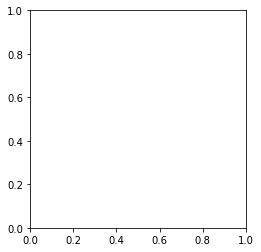

In [14]:
# plot and check the primary cities
!
primary_geo.plot()

# Plot and check the points
Before we run anything, let's see if the points are where they're supposed to be. 

Let's load up an image of the world map and plot the points on the map. 

Geopandas has their own stored map, so let's use that. 

In [ ]:
# get a world map up
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world

In [ ]:
# plot the world map
world.plot()

In [ ]:
# plot both at the same time
primary_geo.plot(ax = world.plot(figsize = (16,9)), figsize = (16,9), color = 'red')

# Setting up the run
Now that we're done preparing the data, it's time to set an optimization up using linear programming. 

Santa going around the world is a case of a Travelling Salesman Problem (TSP), a classic problem in computer science. 

How can Santa tour around the world once, stopping in each city once only, and starting and ending at the same point?

![TSP](https://mathworld.wolfram.com/images/eps-gif/TravelingSalesmanProblem_1000.gif)

It's a surprisingly hard problem, because the complexity for a brute-force approach is O(n!).

![Complexity](https://miro.medium.com/max/1400/1*5ZLci3SuR0zM_QlZOADv8Q.jpeg)

### The approach
Let's use two things:
1. Linear Programming (LP)
2. Subtour elimination constraints (SEC)

----------------

1. Linear Programming

We frame TSP as a linear program

![TSP LP](https://wikimedia.org/api/rest_v1/media/math/render/svg/e34f8bf0f9cfd888592c2376150659eb2626d683)

x = city, c = city distance, i & j = arbitrary indices

2. Subtour elimination constraints (SEC)
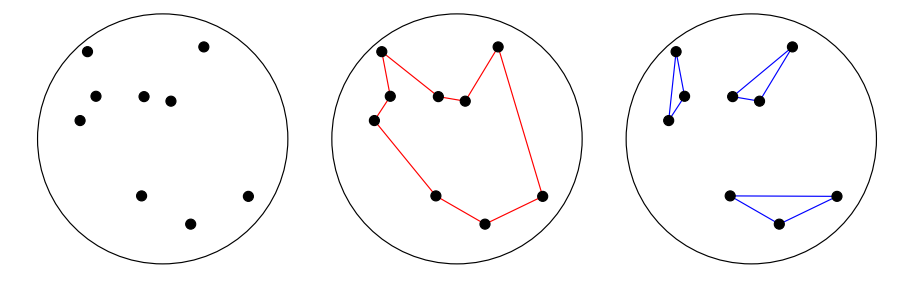

We eliminate subtours by specifiying that each set of cities must have a city that visits another subtour once.

In [ ]:
# create a TSP class
class TSP():
    # instantiate the variables
    cities = None
    santa = None
    variables_dict = None
    x = None
    path = None
    sec_constraints = 0
    execution_time = 0

    # define the init method
    def __init__(self):
        self.cities = primary_geo
        
    def build_model(self):
        # initialize the problem
        santa = LpProblem("santa", LpMinimize)

        # generate distances between cities
        w = h = self.cities.shape[0]
        distances = [[0 for x in range(w)] for y in range(h)] # empty distances

        # get the progress bar
        for index_a, row_a in tqdm(self.cities.iterrows(), total=self.cities.shape[0]):
            lat_a = row_a["lat"]
            lng_a = row_a["lng"]
            for index_b, row_b in self.cities.iterrows():
                lat_b = row_b["lat"]
                lng_b = row_b["lng"]
                distances[index_a][index_b] = self.calculate_distance(lat_a, lng_a, lat_b, lng_b)

        # generate dictionary to create the Linear Program decision variables
        distances_dict = dict(((a, b), distances[a][b]) for a in self.cities.index for b in self.cities.index if a != b)
        
        # the objective function for the LP
        x = LpVariable.dicts('x', distances_dict, 0, 1, LpBinary)
        self.x = x
        self.variables_dict = dict([(str(value), key) for key, value in x.items()])

        # set the cost as a constraint for the LP
        cost = lpSum([x[(i, j)] * distances_dict[(i, j)] for (i, j) in distances_dict])

        # add cost function to the model
        santa += cost

        # add other constraints, after this we will only need to add the subtour elimination constraints!
        for k in self.cities.index:
            # every site has exactly one inbound connection
            santa += lpSum([x[(i, k)] for i in self.cities.index if (i, k) in x]) == 1
            # every site has exactly one outbound connection
            santa += lpSum([x[(k, i)] for i in self.cities.index if (k, i) in x]) == 1

        self.distances_dict = distances_dict
        self.santa = santa

    def add_subtour_constraints(self):
        # generate the graph from the current solution
        varsdict = {}
        for v in self.santa.variables():
            if v.varValue == 1:
                varsdict[v.name] = v.varValue

        # instantiate graph
        G = nx.Graph()
        
        # add nodes to the Graph
        for index_a, row_a in self.cities.iterrows():
            lat_a = row_a["lat"]
            lng_a = row_a["lng"]
            G.add_node(index_a, pos=(lat_a, lng_a))

        # add edges according to solution
        for k in varsdict:
            tmp_node = self.variables_dict[k]
            G.add_edge(tmp_node[0], tmp_node[1])

        # if the number of connected components is 1, we found the optimal path
        nr_connected_components = nx.number_connected_components(G)
        if nr_connected_components == 1:
            return True

        # get all the connected components. If there are more than 1, then there are subtours
        components = nx.connected_components(G)
        for c in tqdm(components, total=nr_connected_components):
            self.santa += lpSum([self.x[(a, b)] for a in c for b in c if a != b]) <= len(c) - 1 # adds addition constraints
            self.sec_constraints += 1

    def build_graph_from_current_solution(self):
        varsdict = {}
        for v in self.santa.variables():
            if v.varValue == 1:
                varsdict[v.name] = v.varValue

        G = nx.Graph()
        # add nodes to the Graph
        for index_a, row_a in self.cities.iterrows():
            lat_a = row_a["lat"]
            lng_a = row_a["lng"]
            G.add_node(index_a, pos=(lat_a, lng_a))

        # add edges according to solution
        for k in varsdict:
            tmp_node = self.variables_dict[k]
            G.add_edge(tmp_node[0], tmp_node[1])

        return G

    def solve(self):
        #   Now, the model is missing the subtour elimination constraints.
        #   The number of these constraints is 2^N-2 where N is the number of cities selected. Too many.
        #   What we can do is:
        #       1. Solve the problem without the Subtour elimination constraints
        #       2. Get the solution and see if there are subtours of length lower than N
        #       3. Add the constraints that exclude those subtours
        #       4. Go to 1 and repeat until there are no more subtours
        start_time = time.time()
        while True:
            self.santa.solve(PULP_CBC_CMD(msg=True))

            G = self.build_graph_from_current_solution()
            pos = nx.get_node_attributes(G, 'pos')
            nx.draw(G, pos, node_size=200)
            plt.show()
            
            # break the while loop once there's only one big cyclic graph
            if self.add_subtour_constraints():
                break

        self.execution_time = time.time() - start_time

    def extract_solution(self):
        # create a graph from the TSP object
        G = self.build_graph_from_current_solution()

        # get the index of North Pole
        santas_idx = self.cities[self.cities["city"] == "North Pole"].index

        # find the cycle of the graph, starting with North Pole's index
        cycle = nx.find_cycle(G, santas_idx)

        # create an empty list called solution
        solution = []

        # loop through the graph's edges
        for e in G.edges:
            edge = []
            edge.append(e[0])
            edge.append(self.cities.iloc[e[0]]["city"])
            edge.append(self.cities.iloc[e[0]]["lat"])
            edge.append(self.cities.iloc[e[0]]["lng"])
            edge.append(self.cities.iloc[e[0]]["population"])

            edge.append(e[1])
            edge.append(self.cities.iloc[e[1]]["city"])
            edge.append(self.cities.iloc[e[1]]["lat"])
            edge.append(self.cities.iloc[e[1]]["lng"])
            edge.append(self.cities.iloc[e[1]]["population"])

            edge.append(self.distances_dict[(e[0], e[1])])
            solution.append(edge)

        # create an empty list for the path
        path = []

        # loop through the graph's cycle and append the index of each city
        for s, e in cycle:
            path.append(s)

        # append the last city - North Pole as the last item in the list
        path.append(path[0])

        # declare columns           
        columns = ["node_a_id", "node_a_city", "node_a_lat", "node_a_lng", "node_a_population", "node_b_id",
                   "node_b_city", "node_b_lat", "node_b_lng", "node_b_population", "distance_km"]

        # create a new attribute called path
        self.path = path

        # create a new attribute called solution
        self.solution = pd.DataFrame(solution, columns=columns)

    def calculate_distance(self, lat_a, lng_a, lat_b, lng_b):
        #   Convert lat lng in radians
        lng_a, lat_a, lng_b, lat_b = map(math.radians, [lng_a, lat_a, lng_b, lat_b])

        d_lat = lat_b - lat_a
        d_lng = lng_a - lng_b

        # declare temp variable
        temp = (
                math.sin(d_lat / 2) ** 2
                + math.cos(lat_a)
                * math.cos(lat_b)
                * math.sin(d_lng / 2) ** 2
        )

        # return distance in km
        return 6373.0 * (2 * math.atan2(math.sqrt(temp), math.sqrt(1 - temp)))

# Begin the run
This is quite easy - just instantiate your TSP object and start building the model for the solver to solve.

In [ ]:
# begin run
tsp = TSP()
tsp.build_model()
tsp.solve()

# Analyzing the results
Now that we're done with the run, let's take a look and see if it's legit.

### Extract path from run
Let's extract the solution out of the TSP run first.

In [ ]:
# call the .extract_solution method
tsp.extract_solution()

# assess how many constraints were added
print("SEC constraints added: {}".format(tsp.sec_constraints))
print("Solution Found in {} seconds".format(tsp.execution_time))

# print the TSP path taken
print(tsp.path)

### Take a look at the solution DataFrame

In [ ]:
# look at the solution attribute
tsp.solution

Do you see anything weird...?

Hint: It's in the top rows.

### Plot the path around the world
Let's get a new GeoDataFrame that shows the TSP path

In [ ]:
# reorder the GeoDataFrame
reordered_primary_geo = primary_geo.reindex(tsp.path)
reordered_primary_geo = reordered_primary_geo.reset_index(drop = True)
reordered_primary_geo

### Get the LineStrings between cities
Now that we have ordered our GeoDataFrame, let's get the LineString between the cities so we can plot them later on.

In [ ]:
# create an empty list
line_list = []

# loop through the GeoDataFrame and create LineString out of the coordinate pairs
for index, row in reordered_primary_geo[:-1].iterrows():
  first_row = reordered_primary_geo.iloc[index]
  second_row = reordered_primary_geo.iloc[index + 1]  

  line_list.append(LineString([
                               (first_row['lng'],first_row['lat']),
                               (second_row['lng'], second_row['lat'])
                               ]))

# create a GeoSeries  
line_drawings = gpd.GeoSeries(line_list, crs = 4326)
line_drawings

In [ ]:
# take a quick look at the GeoSeries
line_drawings.plot()

# Putting it all together
Now we that have our:
1. cities
2. world map
3. path

...let's put everything together! 

In [ ]:
# plot everything into a plot
lineplot = line_drawings.plot(color = 'orange', figsize = (16,9))
worldplot = world.plot(ax = lineplot, figsize = (16,9))

primary_geo.plot(ax = worldplot, figsize = (16,9), color = 'red')